# 02 - Time Series Analysis and Stationarity

This notebook focuses on:
1. Time series decomposition (trend, seasonality, residuals)
2. Stationarity testing and transformations
3. Autocorrelation and partial autocorrelation analysis
4. Feature engineering for time series


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn')
sns.set_palette("husl")


In [2]:
# Load the clean dataset and ranking data
print("=== LOADING DATA ===")

# Load the clean book dataset
df = pd.read_csv('../data/amazon_com_extras_clean.csv')
print(f"Book dataset shape: {df.shape}")

# Load ranking data from JSON files
ranks_dir = '../data/ranks/ranks/'
if os.path.exists(ranks_dir):
    rank_files = [f for f in os.listdir(ranks_dir) if f.endswith('.json')]
    print(f"Found {len(rank_files)} ranking files")
    
    # Sample a few files to understand structure
    sample_files = rank_files[:3]
    for file in sample_files:
        file_path = os.path.join(ranks_dir, file)
        print(f"\n--- {file} ---")
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                print(f"Number of rank entries: {len(data)}")
                # Show first few entries
                for i, entry in enumerate(list(data.items())[:3]):
                    print(f"  {entry[0]}: {entry[1]}")
        except Exception as e:
            print(f"Error reading {file}: {e}")
else:
    print("No ranks directory found")

# Define time series splits (from step 1)
print("\n=== TIME SERIES SPLITS ===")
# Get all timestamps from ranking files (they are Unix timestamps)
all_timestamps = []
for file in rank_files[:10]:  # Sample first 10 files to get date range
    file_path = os.path.join(ranks_dir, file)
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            # The data structure is: {"timestamp": rank_value}
            timestamps = list(data.keys())
            all_timestamps.extend(timestamps)
    except:
        continue

if all_timestamps:
    # Convert Unix timestamps to datetime and sort
    all_dates = pd.to_datetime([int(ts) for ts in all_timestamps], unit='s')
    all_dates = sorted(all_dates)
    
    print(f"Date range: {all_dates[0]} to {all_dates[-1]}")
    print(f"Total unique dates: {len(all_dates)}")
    
    # Define splits (80% in-time, 20% out-of-time)
    split_point = int(len(all_dates) * 0.8)
    in_time_dates = all_dates[:split_point]
    out_of_time_dates = all_dates[split_point:]
    
    print(f"\nIn-time sample: {in_time_dates[0]} to {in_time_dates[-1]} ({len(in_time_dates)} days)")
    print(f"Out-of-time sample: {out_of_time_dates[0]} to {out_of_time_dates[-1]} ({len(out_of_time_dates)} days)")
    
    # Store for later use
    in_time_start = in_time_dates[0]
    in_time_end = in_time_dates[-1]
    out_of_time_start = out_of_time_dates[0]
    out_of_time_end = out_of_time_dates[-1]
    
    print(f"\nSplit date: {out_of_time_start}")
    print(f"Total books with ranking data: {len(rank_files)}")
else:
    print("No valid timestamps found in ranking files")


=== LOADING DATA ===
Book dataset shape: (63748, 6)
Found 51440 ranking files

--- B0124XGWN4_com.json ---
Number of rank entries: 5144
  1483266592: 355208
  1483270308: 361346
  1483276721: 365941

--- 1631401114_com.json ---
Number of rank entries: 776
  1525564877: 107874
  1525567447: 114855
  1525574792: 131333

--- 0957400721_com.json ---
Number of rank entries: 1050
  1523362170: 362274
  1523369125: 361613
  1523370217: 80469

=== TIME SERIES SPLITS ===
Date range: 2017-01-01 10:04:49 to 2018-06-30 03:08:17
Total unique dates: 33022

In-time sample: 2017-01-01 10:04:49 to 2018-04-16 04:19:10 (26417 days)
Out-of-time sample: 2018-04-16 04:20:21 to 2018-06-30 03:08:17 (6605 days)

Split date: 2018-04-16 04:20:21
Total books with ranking data: 51440


In [3]:
# Load specific book ranking data for time series analysis
print("=== LOADING SPECIFIC BOOK RANKING DATA ===")

# Select a specific book for analysis (you can change this)
selected_asin = "0002247399"  # From the sample we saw earlier
target_file = f"{selected_asin}_com.json"

if target_file in rank_files:
    file_path = os.path.join(ranks_dir, target_file)
    
    # Load the ranking data
    with open(file_path, 'r') as f:
        ranking_data = json.load(f)
    
    print(f"Loaded ranking data for ASIN: {selected_asin}")
    print(f"Number of data points: {len(ranking_data)}")
    
    # Convert to DataFrame
    ts_data = pd.DataFrame(list(ranking_data.items()), columns=['timestamp', 'rank'])
    ts_data['timestamp'] = pd.to_datetime(ts_data['timestamp'], unit='s')
    ts_data = ts_data.sort_values('timestamp').reset_index(drop=True)
    ts_data = ts_data.set_index('timestamp')
    
    print(f"Time series shape: {ts_data.shape}")
    print(f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")
    print(f"Missing values: {ts_data['rank'].isnull().sum()}")
    print(f"Rank range: {ts_data['rank'].min()} to {ts_data['rank'].max()}")
    
    # Split into in-time and out-of-time samples
    split_date = out_of_time_start
    in_time_data = ts_data[ts_data.index <= split_date].copy()
    out_of_time_data = ts_data[ts_data.index > split_date].copy()
    
    print(f"\nIn-time sample: {len(in_time_data)} points")
    print(f"Out-of-time sample: {len(out_of_time_data)} points")
    
else:
    print(f"File {target_file} not found in ranking data")
    print("Available files (first 10):")
    for file in rank_files[:10]:
        print(f"  {file}")


=== LOADING SPECIFIC BOOK RANKING DATA ===
Loaded ranking data for ASIN: 0002247399
Number of data points: 1559
Time series shape: (1559, 1)
Date range: 2017-01-01 14:09:35 to 2018-06-30 03:04:17
Missing values: 0
Rank range: 148566 to 2958944

In-time sample: 1415 points
Out-of-time sample: 144 points


=== TESTING MULTIPLE PERIODS ===
Data length: 1559 days (51.2 months)
Period   7: OK - 222.7 cycles available (reliability: 1.00)
Period   7 (additive    ): Trend=0.9754, Seasonal=0.0001, Residual=0.0127
Period   7 (multiplicative): Trend=0.9754, Seasonal=0.0000, Residual=0.0000
Period  14: OK - 111.4 cycles available (reliability: 1.00)
Period  14 (additive    ): Trend=0.9501, Seasonal=0.0001, Residual=0.0261
Period  14 (multiplicative): Trend=0.9501, Seasonal=0.0000, Residual=0.0000
Period  30: OK - 52.0 cycles available (reliability: 1.00)
Period  30 (additive    ): Trend=0.8953, Seasonal=0.0008, Residual=0.0560
Period  30 (multiplicative): Trend=0.8953, Seasonal=0.0000, Residual=0.0000
Period  60: OK - 26.0 cycles available (reliability: 1.00)
Period  60 (additive    ): Trend=0.7905, Seasonal=0.0045, Residual=0.0920
Period  60 (multiplicative): Trend=0.7905, Seasonal=0.0000, Residual=0.0000
Period  90: OK - 17.3 cycles available (reliability: 1.00)
Period  90 (additive    ): Trend=

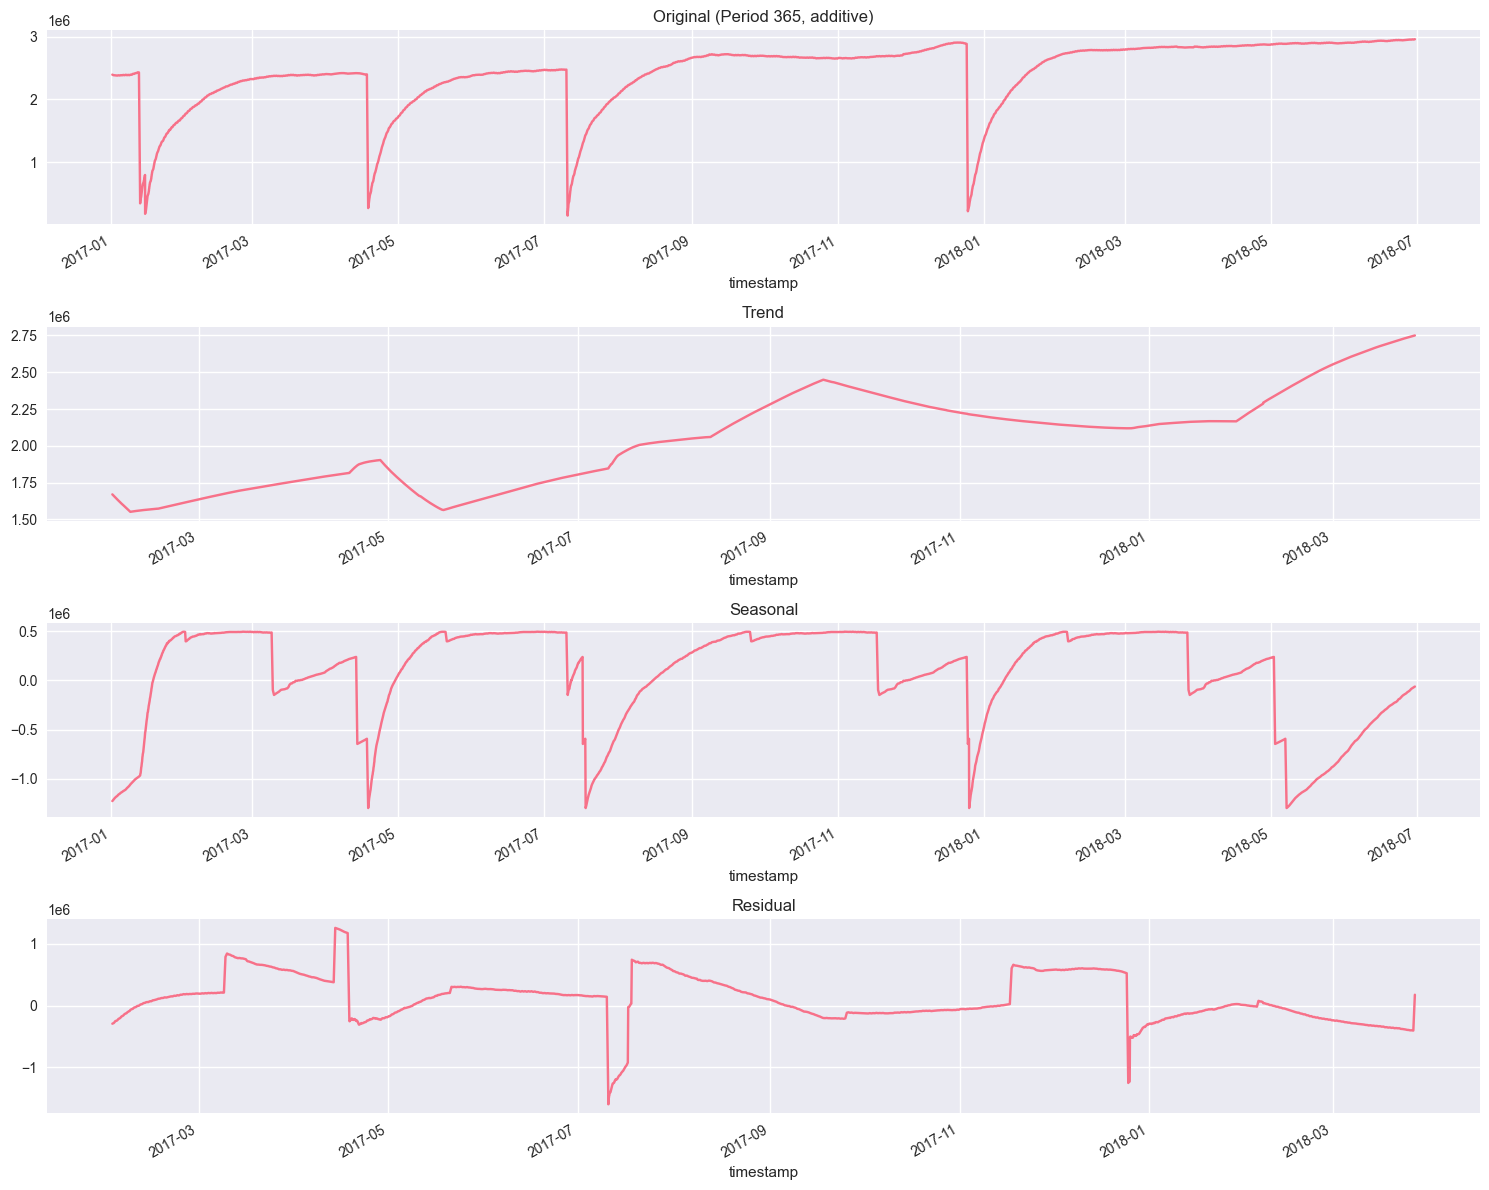


=== DETAILED STATISTICS FOR BEST MODEL ===
Trend strength: 0.1243
Seasonal strength: 0.4433
Residual strength: 0.3490


In [4]:
# Time series decomposition with multiple periods
if 'ts_data' in locals() and not ts_data.empty:
    # Remove missing values for decomposition
    ts_clean = ts_data['rank'].dropna()
    
    print("=== TESTING MULTIPLE PERIODS ===")
    
    # Test different periods for seasonal patterns
    periods_to_test = [7, 14, 30, 60, 90, 180, 365]  # Weekly, bi-weekly, monthly, etc.
    models_to_test = ['additive', 'multiplicative']
    
    # Calculate data length and reliability requirements
    data_length_days = len(ts_clean)
    data_length_months = data_length_days / 30.44  # Average days per month
    
    print(f"Data length: {data_length_days} days ({data_length_months:.1f} months)")
    print("=" * 60)
    
    best_period = None
    best_model = None
    best_seasonal_strength = 0
    results = []
    
    for period in periods_to_test:
        # Calculate reliability metrics
        cycles_available = data_length_days / period
        reliability_score = min(cycles_available / 3, 1.0)  # Need 3+ cycles for reliability
        
        # Skip periods that are too large for the data
        if period >= len(ts_clean) // 2:
            print(f"Period {period:3d}: Skipped (too large for data length {len(ts_clean)})")
            continue
            
        # Warn about unreliable periods
        if cycles_available < 2:
            print(f"Period {period:3d}: WARNING - Only {cycles_available:.1f} cycles available (need 2+ for reliability)")
        elif cycles_available < 3:
            print(f"Period {period:3d}: CAUTION - Only {cycles_available:.1f} cycles available (need 3+ for good reliability)")
        else:
            print(f"Period {period:3d}: OK - {cycles_available:.1f} cycles available (reliability: {reliability_score:.2f})")
            
        for model in models_to_test:
            try:
                decomposition = seasonal_decompose(ts_clean, model=model, period=period)
                
                # Calculate component strengths
                trend_strength = np.var(decomposition.trend.dropna()) / np.var(decomposition.observed)
                seasonal_strength = np.var(decomposition.seasonal.dropna()) / np.var(decomposition.observed)
                residual_strength = np.var(decomposition.resid.dropna()) / np.var(decomposition.observed)
                
                results.append({
                    'period': period,
                    'model': model,
                    'trend_strength': trend_strength,
                    'seasonal_strength': seasonal_strength,
                    'residual_strength': residual_strength,
                    'cycles_available': cycles_available,
                    'reliability_score': reliability_score
                })
                
                print(f"Period {period:3d} ({model:12s}): Trend={trend_strength:.4f}, Seasonal={seasonal_strength:.4f}, Residual={residual_strength:.4f}")
                
                # Track best seasonal strength (weighted by reliability)
                weighted_seasonal_strength = seasonal_strength * reliability_score
                if weighted_seasonal_strength > best_seasonal_strength:
                    best_seasonal_strength = weighted_seasonal_strength
                    best_period = period
                    best_model = model
                    best_decomposition = decomposition
                    
            except Exception as e:
                print(f"Period {period:3d} ({model:12s}): Failed - {str(e)[:50]}...")
    
    # Display results summary
    print(f"\n=== BEST DECOMPOSITION (RELIABILITY-WEIGHTED) ===")
    print(f"Best period: {best_period}")
    print(f"Best model: {best_model}")
    print(f"Weighted seasonal strength: {best_seasonal_strength:.4f}")
    
    # Create results DataFrame for analysis
    results_df = pd.DataFrame(results)
    if not results_df.empty:
        print(f"\n=== TOP 5 PERIODS BY SEASONAL STRENGTH ===")
        top_periods = results_df.nlargest(5, 'seasonal_strength')
        for _, row in top_periods.iterrows():
            print(f"Period {row['period']:3d} ({row['model']:12s}): Seasonal={row['seasonal_strength']:.4f}, Cycles={row['cycles_available']:.1f}, Reliability={row['reliability_score']:.2f}")
        
        print(f"\n=== TOP 5 PERIODS BY RELIABILITY-WEIGHTED SCORE ===")
        results_df['weighted_score'] = results_df['seasonal_strength'] * results_df['reliability_score']
        top_weighted = results_df.nlargest(5, 'weighted_score')
        for _, row in top_weighted.iterrows():
            print(f"Period {row['period']:3d} ({row['model']:12s}): Weighted={row['weighted_score']:.4f}, Seasonal={row['seasonal_strength']:.4f}, Reliability={row['reliability_score']:.2f}")
        
        print(f"\n=== RECOMMENDATION ===")
        if not top_weighted.empty:
            recommended = top_weighted.iloc[0]
            print(f"Recommended period: {recommended['period']} ({recommended['model']} model)")
            print(f"Reason: Best balance of seasonal strength ({recommended['seasonal_strength']:.4f}) and reliability ({recommended['reliability_score']:.2f})")
            print(f"Cycles available: {recommended['cycles_available']:.1f}")
            
            if recommended['cycles_available'] < 3:
                print("⚠️  WARNING: Less than 3 cycles available. Consider collecting more data for better reliability.")
            elif recommended['cycles_available'] < 5:
                print("⚠️  CAUTION: Less than 5 cycles available. Results may be less reliable.")
            else:
                print("✅ Good: Sufficient cycles for reliable seasonal analysis.")
    
    # Plot the best decomposition
    if best_period is not None:
        print(f"\n=== PLOTTING BEST DECOMPOSITION (Period {best_period}, {best_model}) ===")
        
        fig, axes = plt.subplots(4, 1, figsize=(15, 12))
        
        best_decomposition.observed.plot(ax=axes[0], title=f'Original (Period {best_period}, {best_model})')
        best_decomposition.trend.plot(ax=axes[1], title='Trend')
        best_decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
        best_decomposition.resid.plot(ax=axes[3], title='Residual')
        
        plt.tight_layout()
        plt.savefig('../plots/time_series_decomposition_best.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print detailed statistics for best model
        print(f"\n=== DETAILED STATISTICS FOR BEST MODEL ===")
        print(f"Trend strength: {np.var(best_decomposition.trend.dropna()) / np.var(best_decomposition.observed):.4f}")
        print(f"Seasonal strength: {np.var(best_decomposition.seasonal.dropna()) / np.var(best_decomposition.observed):.4f}")
        print(f"Residual strength: {np.var(best_decomposition.resid.dropna()) / np.var(best_decomposition.observed):.4f}")
        
        # Store best decomposition for later use
        decomposition = best_decomposition
        
    else:
        print("No successful decomposition found!")
        
else:
    print("No time series data available for decomposition")


=== PERIOD COMPARISON VISUALIZATION ===


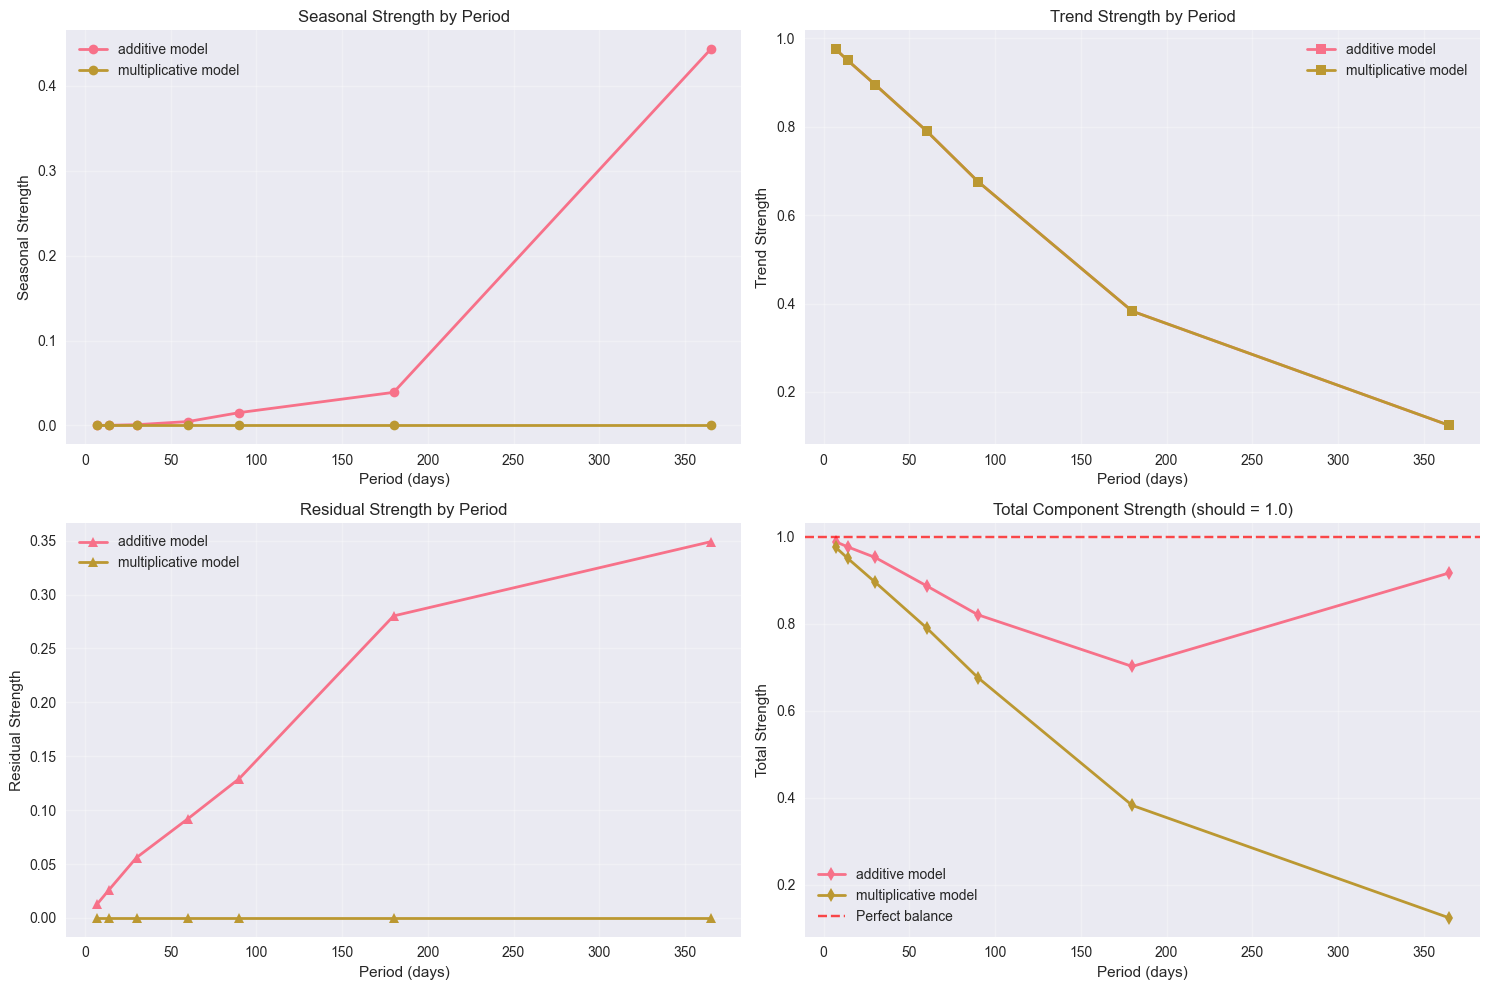


=== INTERPRETATION GUIDE ===
• Higher seasonal strength = stronger repeating patterns
• Lower residual strength = better model fit (less unexplained variation)
• Total strength should be close to 1.0 for good decomposition
• Look for periods with high seasonal strength and low residual strength

=== BEST PERIODS BY CRITERIA ===
Best seasonal pattern:
  Period 365 (additive): 0.4433
Best model fit (lowest residual):
  Period 7 (multiplicative): 0.0000
Best overall balance:
  Period 365 (additive): Balance=0.0943


In [5]:
# Visualize period comparison results
if 'results_df' in locals() and not results_df.empty:
    print("=== PERIOD COMPARISON VISUALIZATION ===")
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Seasonal strength by period
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        axes[0, 0].plot(model_data['period'], model_data['seasonal_strength'], 
                       marker='o', label=f'{model} model', linewidth=2)
    axes[0, 0].set_title('Seasonal Strength by Period')
    axes[0, 0].set_xlabel('Period (days)')
    axes[0, 0].set_ylabel('Seasonal Strength')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Trend strength by period
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        axes[0, 1].plot(model_data['period'], model_data['trend_strength'], 
                       marker='s', label=f'{model} model', linewidth=2)
    axes[0, 1].set_title('Trend Strength by Period')
    axes[0, 1].set_xlabel('Period (days)')
    axes[0, 1].set_ylabel('Trend Strength')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Residual strength by period
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        axes[1, 0].plot(model_data['period'], model_data['residual_strength'], 
                       marker='^', label=f'{model} model', linewidth=2)
    axes[1, 0].set_title('Residual Strength by Period')
    axes[1, 0].set_xlabel('Period (days)')
    axes[1, 0].set_ylabel('Residual Strength')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Component balance (trend + seasonal + residual = 1)
    for model in results_df['model'].unique():
        model_data = results_df[results_df['model'] == model]
        total_strength = model_data['trend_strength'] + model_data['seasonal_strength'] + model_data['residual_strength']
        axes[1, 1].plot(model_data['period'], total_strength, 
                       marker='d', label=f'{model} model', linewidth=2)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect balance')
    axes[1, 1].set_title('Total Component Strength (should = 1.0)')
    axes[1, 1].set_xlabel('Period (days)')
    axes[1, 1].set_ylabel('Total Strength')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../plots/period_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print interpretation guide
    print("\n=== INTERPRETATION GUIDE ===")
    print("• Higher seasonal strength = stronger repeating patterns")
    print("• Lower residual strength = better model fit (less unexplained variation)")
    print("• Total strength should be close to 1.0 for good decomposition")
    print("• Look for periods with high seasonal strength and low residual strength")
    
    # Show best periods for different criteria
    print(f"\n=== BEST PERIODS BY CRITERIA ===")
    print("Best seasonal pattern:")
    best_seasonal = results_df.loc[results_df['seasonal_strength'].idxmax()]
    print(f"  Period {best_seasonal['period']} ({best_seasonal['model']}): {best_seasonal['seasonal_strength']:.4f}")
    
    print("Best model fit (lowest residual):")
    best_fit = results_df.loc[results_df['residual_strength'].idxmin()]
    print(f"  Period {best_fit['period']} ({best_fit['model']}): {best_fit['residual_strength']:.4f}")
    
    print("Best overall balance:")
    results_df['balance_score'] = results_df['seasonal_strength'] - results_df['residual_strength']
    best_balance = results_df.loc[results_df['balance_score'].idxmax()]
    print(f"  Period {best_balance['period']} ({best_balance['model']}): Balance={best_balance['balance_score']:.4f}")
    
else:
    print("No decomposition results available for visualization")


In [6]:
# Stationarity testing
print("=== STATIONARITY TESTING EXPLAINED ===")
print("""
Stationarity is a key concept in time series analysis:

WHAT IS STATIONARITY?
• A stationary time series has constant statistical properties over time
• Mean, variance, and autocorrelation don't change over time
• Most forecasting models require stationarity

WHY IS IT IMPORTANT?
• Non-stationary series have trends/seasonality that can mislead models
• Stationary series are easier to model and forecast
• Many models (ARIMA, etc.) assume stationarity

HOW DO WE TEST IT?
• ADF Test: Tests for unit root (non-stationarity)
• KPSS Test: Tests for stationarity around a trend
• We use BOTH tests for comprehensive analysis

INTERPRETATION:
• ADF p-value < 0.05: Series is stationary (reject null hypothesis)
• KPSS p-value > 0.05: Series is stationary (fail to reject null hypothesis)
• If tests disagree, the series is likely trend-stationary
""")

def test_stationarity(timeseries, title='Time Series'):
    """
    Test stationarity using ADF and KPSS tests
    """
    print(f'\nResults of {title}:')
    print('-' * 50)
    
    # ADF Test
    adf_result = adfuller(timeseries.dropna())
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    
    if adf_result[1] <= 0.05:
        print("ADF Test: Series is stationary (reject null hypothesis)")
    else:
        print("ADF Test: Series is non-stationary (fail to reject null hypothesis)")
    
    print('\n' + '-' * 30)
    
    # KPSS Test
    kpss_result = kpss(timeseries.dropna())
    print('KPSS Statistic:', kpss_result[0])
    print('p-value:', kpss_result[1])
    print('Critical Values:')
    for key, value in kpss_result[3].items():
        print(f'\t{key}: {value}')
    
    if kpss_result[1] >= 0.05:
        print("KPSS Test: Series is stationary (fail to reject null hypothesis)")
    else:
        print("KPSS Test: Series is non-stationary (reject null hypothesis)")
    
    # Provide interpretation
    print('\n' + '=' * 50)
    print('INTERPRETATION:')
    if adf_result[1] <= 0.05 and kpss_result[1] >= 0.05:
        print('✅ Both tests agree: Series is STATIONARY')
        print('   → Can proceed with ARIMA modeling')
    elif adf_result[1] > 0.05 and kpss_result[1] < 0.05:
        print('✅ Both tests agree: Series is NON-STATIONARY')
        print('   → Need to difference or transform the series')
    else:
        print('⚠️  Tests disagree: Series is likely TREND-STATIONARY')
        print('   → Consider detrending or using trend-stationary models')
        print('   → ADF suggests stationarity, KPSS suggests non-stationarity')
    
    return adf_result, kpss_result

# Test stationarity of original series
if 'ts_clean' in locals() and not ts_clean.empty:
    print("\n" + "="*60)
    print("TESTING STATIONARITY OF ORIGINAL SERIES")
    print("="*60)
    
    adf_orig, kpss_orig = test_stationarity(ts_clean, 'Original Time Series')
    
    # Test stationarity after first difference
    print("\n" + "="*60)
    print("TESTING STATIONARITY AFTER FIRST DIFFERENCE")
    print("="*60)
    print("First difference removes trend and makes series more stationary")
    
    ts_diff = ts_clean.diff().dropna()
    if not ts_diff.empty:
        adf_diff, kpss_diff = test_stationarity(ts_diff, 'First Difference')
        
        # Test stationarity after log transformation
        print("\n" + "="*60)
        print("TESTING STATIONARITY AFTER LOG TRANSFORMATION")
        print("="*60)
        print("Log transformation stabilizes variance")
        
        if (ts_clean > 0).all():
            ts_log = np.log(ts_clean)
            adf_log, kpss_log = test_stationarity(ts_log, 'Log Transform')
            
            # Test stationarity after log + difference
            print("\n" + "="*60)
            print("TESTING STATIONARITY AFTER LOG + FIRST DIFFERENCE")
            print("="*60)
            print("Combines variance stabilization and trend removal")
            
            ts_log_diff = ts_log.diff().dropna()
            if not ts_log_diff.empty:
                adf_log_diff, kpss_log_diff = test_stationarity(ts_log_diff, 'Log + First Difference')
        else:
            print("Cannot apply log transformation: series contains zero or negative values")
    
    # Summary and recommendations
    print("\n" + "="*60)
    print("STATIONARITY TESTING SUMMARY")
    print("="*60)
    
    # Create summary table
    summary_data = []
    
    # Original series
    summary_data.append({
        'Series': 'Original',
        'ADF_pvalue': adf_orig[1],
        'KPSS_pvalue': kpss_orig[1],
        'ADF_Stationary': adf_orig[1] <= 0.05,
        'KPSS_Stationary': kpss_orig[1] >= 0.05
    })
    
    # First difference
    if 'ts_diff' in locals() and not ts_diff.empty:
        summary_data.append({
            'Series': 'First Difference',
            'ADF_pvalue': adf_diff[1],
            'KPSS_pvalue': kpss_diff[1],
            'ADF_Stationary': adf_diff[1] <= 0.05,
            'KPSS_Stationary': kpss_diff[1] >= 0.05
        })
    
    # Log transform
    if 'ts_log' in locals() and not ts_log.empty:
        summary_data.append({
            'Series': 'Log Transform',
            'ADF_pvalue': adf_log[1],
            'KPSS_pvalue': kpss_log[1],
            'ADF_Stationary': adf_log[1] <= 0.05,
            'KPSS_Stationary': kpss_log[1] >= 0.05
        })
    
    # Log + difference
    if 'ts_log_diff' in locals() and not ts_log_diff.empty:
        summary_data.append({
            'Series': 'Log + Difference',
            'ADF_pvalue': adf_log_diff[1],
            'KPSS_pvalue': kpss_log_diff[1],
            'ADF_Stationary': adf_log_diff[1] <= 0.05,
            'KPSS_Stationary': kpss_log_diff[1] >= 0.05
        })
    
    # Display summary
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False, float_format='%.4f'))
    
    # Find best transformation
    print(f"\n=== RECOMMENDATIONS ===")
    best_transformation = None
    for _, row in summary_df.iterrows():
        if row['ADF_Stationary'] and row['KPSS_Stationary']:
            best_transformation = row['Series']
            break
    
    if best_transformation:
        print(f"✅ Best transformation: {best_transformation}")
        print(f"   → Both ADF and KPSS tests indicate stationarity")
        print(f"   → Use this transformation for ARIMA modeling")
    else:
        print("⚠️  No transformation achieved full stationarity")
        print("   → Consider using trend-stationary models")
        print("   → Or use models that handle non-stationarity (Prophet, LSTM)")
        
        # Find the best available option
        best_option = summary_df.loc[summary_df['ADF_Stationary'].idxmax()]
        print(f"   → Best available: {best_option['Series']} (ADF indicates stationarity)")
    
else:
    print("No time series data available for stationarity testing")


=== STATIONARITY TESTING EXPLAINED ===

Stationarity is a key concept in time series analysis:

WHAT IS STATIONARITY?
• A stationary time series has constant statistical properties over time
• Mean, variance, and autocorrelation don't change over time
• Most forecasting models require stationarity

WHY IS IT IMPORTANT?
• Non-stationary series have trends/seasonality that can mislead models
• Stationary series are easier to model and forecast
• Many models (ARIMA, etc.) assume stationarity

HOW DO WE TEST IT?
• ADF Test: Tests for unit root (non-stationarity)
• KPSS Test: Tests for stationarity around a trend
• We use BOTH tests for comprehensive analysis

INTERPRETATION:
• ADF p-value < 0.05: Series is stationary (reject null hypothesis)
• KPSS p-value > 0.05: Series is stationary (fail to reject null hypothesis)
• If tests disagree, the series is likely trend-stationary


TESTING STATIONARITY OF ORIGINAL SERIES

Results of Original Time Series:
----------------------------------------

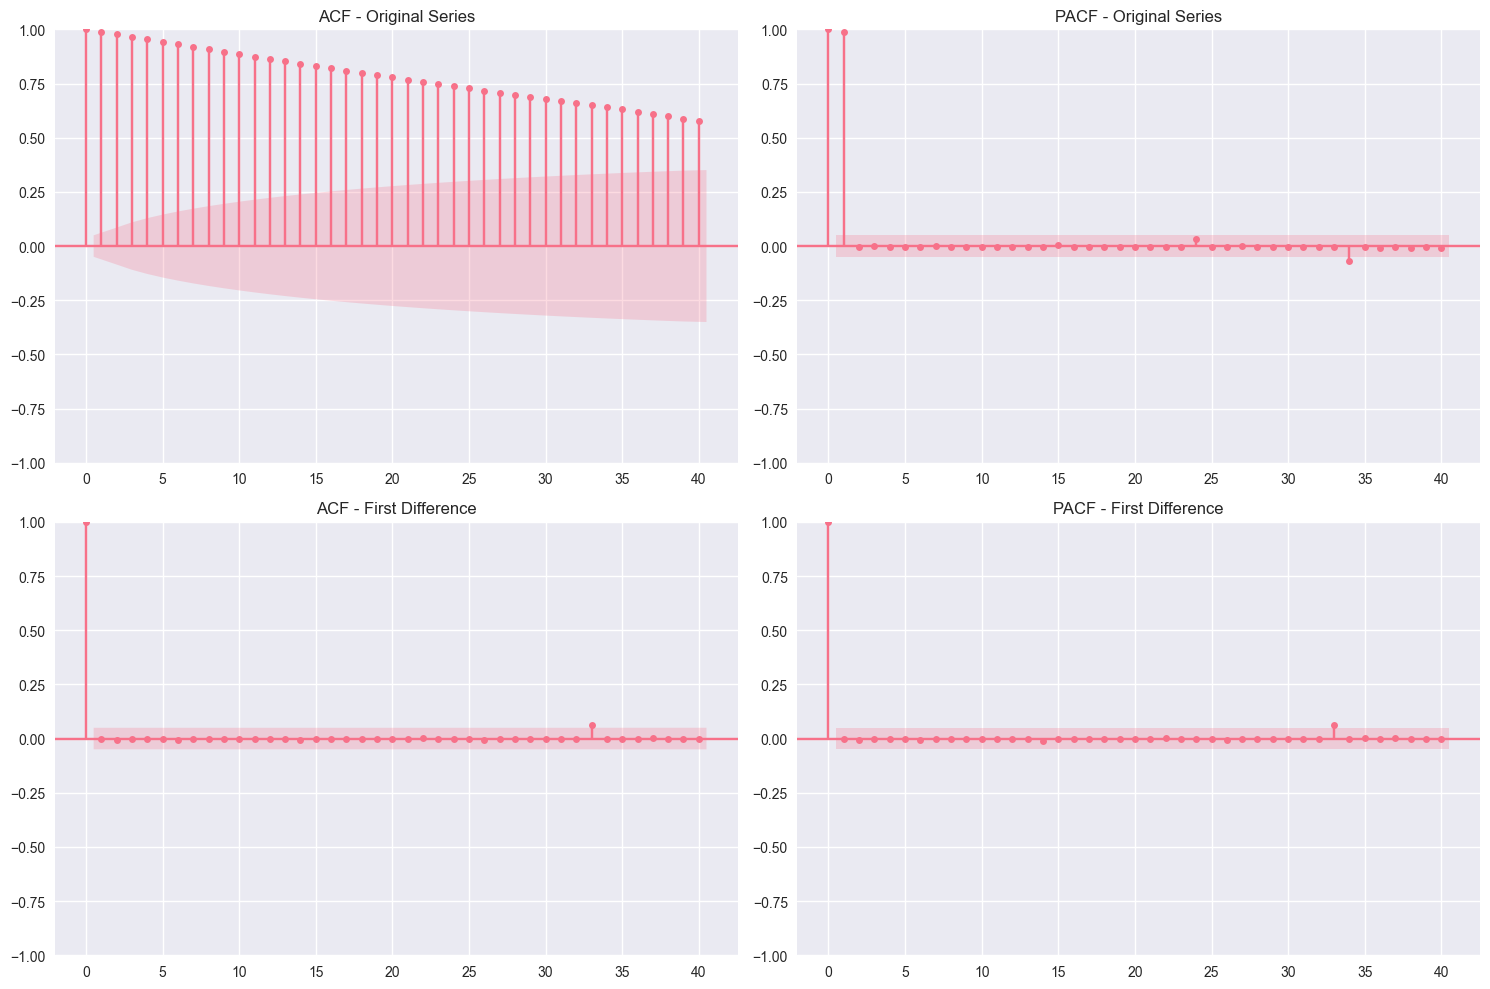

ACF/PACF Analysis Insights:
1. ACF shows correlation between series and its lags
2. PACF shows partial correlation after removing effects of shorter lags
3. Look for significant lags to determine AR and MA components
4. Slow decay in ACF suggests non-stationarity
5. Sharp cutoff in PACF suggests AR component
6. Sharp cutoff in ACF suggests MA component


In [7]:
# Autocorrelation and Partial Autocorrelation Analysis
if 'ts_clean' in locals() and not ts_clean.empty:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original series
    plot_acf(ts_clean, ax=axes[0, 0], lags=40, title='ACF - Original Series')
    plot_pacf(ts_clean, ax=axes[0, 1], lags=40, title='PACF - Original Series')
    
    # First difference
    if 'ts_diff' in locals() and not ts_diff.empty:
        plot_acf(ts_diff, ax=axes[1, 0], lags=40, title='ACF - First Difference')
        plot_pacf(ts_diff, ax=axes[1, 1], lags=40, title='PACF - First Difference')
    
    plt.tight_layout()
    plt.savefig('../plots/acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print ACF/PACF insights
    print("ACF/PACF Analysis Insights:")
    print("=" * 50)
    print("1. ACF shows correlation between series and its lags")
    print("2. PACF shows partial correlation after removing effects of shorter lags")
    print("3. Look for significant lags to determine AR and MA components")
    print("4. Slow decay in ACF suggests non-stationarity")
    print("5. Sharp cutoff in PACF suggests AR component")
    print("6. Sharp cutoff in ACF suggests MA component")
else:
    print("No time series data available for ACF/PACF analysis")


In [8]:
# Feature engineering for time series
def create_time_features(ts_data, target_col='rank'):
    """
    Create time-based features for time series modeling
    """
    df_features = ts_data.copy()
    
    # Time-based features (using the datetime index)
    df_features['year'] = df_features.index.year
    df_features['month'] = df_features.index.month
    df_features['day'] = df_features.index.day
    df_features['dayofweek'] = df_features.index.dayofweek
    df_features['dayofyear'] = df_features.index.dayofyear
    df_features['week'] = df_features.index.isocalendar().week
    df_features['quarter'] = df_features.index.quarter
    
    # Cyclical encoding
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['dayofweek_sin'] = np.sin(2 * np.pi * df_features['dayofweek'] / 7)
    df_features['dayofweek_cos'] = np.cos(2 * np.pi * df_features['dayofweek'] / 7)
    
    # Lag features
    for lag in [1, 7, 30]:  # 1 day, 1 week, 1 month lags
        df_features[f'{target_col}_lag_{lag}'] = df_features[target_col].shift(lag)
    
    # Rolling statistics
    for window in [7, 30]:  # 1 week, 1 month windows
        df_features[f'{target_col}_rolling_mean_{window}'] = df_features[target_col].rolling(window=window).mean()
        df_features[f'{target_col}_rolling_std_{window}'] = df_features[target_col].rolling(window=window).std()
        df_features[f'{target_col}_rolling_min_{window}'] = df_features[target_col].rolling(window=window).min()
        df_features[f'{target_col}_rolling_max_{window}'] = df_features[target_col].rolling(window=window).max()
    
    # Difference features
    df_features[f'{target_col}_diff_1'] = df_features[target_col].diff(1)
    df_features[f'{target_col}_diff_7'] = df_features[target_col].diff(7)
    
    # Percentage change
    df_features[f'{target_col}_pct_change_1'] = df_features[target_col].pct_change(1)
    df_features[f'{target_col}_pct_change_7'] = df_features[target_col].pct_change(7)
    
    return df_features

# Create features for in-time sample
if 'in_time_data' in locals() and not in_time_data.empty:
    in_time_features = create_time_features(in_time_data, 'rank')
    out_of_time_features = create_time_features(out_of_time_data, 'rank')
    
    print(f"Original features: {in_time_data.shape[1]}")
    print(f"Features after engineering: {in_time_features.shape[1]}")
    print(f"New features added: {in_time_features.shape[1] - in_time_data.shape[1]}")
    
    # Save engineered features
    in_time_features.to_csv('../data/in_time_features.csv')
    out_of_time_features.to_csv('../data/out_of_time_features.csv')
    
    print("\nEngineered features saved to data/ directory")
    
    # Display feature importance (correlation with target)
    feature_corr = in_time_features.corr()['rank'].abs().sort_values(ascending=False)
    print("\nTop 10 features by correlation with target:")
    print(feature_corr.head(10))
else:
    print("Cannot create features - missing time series data")


Original features: 1
Features after engineering: 27
New features added: 26

Engineered features saved to data/ directory

Top 10 features by correlation with target:
rank                    1.000000
rank_rolling_min_7      0.999537
rank_rolling_min_30     0.990251
rank_lag_1              0.987273
rank_rolling_mean_7     0.976318
rank_rolling_max_7      0.926188
rank_lag_7              0.911915
rank_rolling_mean_30    0.889551
rank_rolling_max_30     0.695848
rank_rolling_std_30     0.668167
Name: rank, dtype: float64


In [9]:
# Summary of time series analysis
print("Time Series Analysis Summary:")
print("=" * 50)

if 'ts_clean' in locals():
    print(f"Time series length: {len(ts_clean)}")
    print(f"Date range: {ts_clean.index.min()} to {ts_clean.index.max()}")
    print(f"Mean value: {ts_clean.mean():.2f}")
    print(f"Standard deviation: {ts_clean.std():.2f}")
    print(f"Missing values: {ts_clean.isnull().sum()}")

print("\nKey Findings:")
print("1. Check stationarity test results above")
print("2. Review ACF/PACF plots for ARIMA parameters")
print("3. Consider seasonal patterns from decomposition")
print("4. Feature engineering completed for ML models")

print("\nNext Steps:")
print("1. Implement ARIMA/SARIMA models based on ACF/PACF analysis")
print("2. Try exponential smoothing methods")
print("3. Implement machine learning models with engineered features")
print("4. Compare model performance on out-of-time sample")


Time Series Analysis Summary:
Time series length: 1559
Date range: 2017-01-01 14:09:35 to 2018-06-30 03:04:17
Mean value: 2040286.32
Standard deviation: 793552.94
Missing values: 0

Key Findings:
1. Check stationarity test results above
2. Review ACF/PACF plots for ARIMA parameters
3. Consider seasonal patterns from decomposition
4. Feature engineering completed for ML models

Next Steps:
1. Implement ARIMA/SARIMA models based on ACF/PACF analysis
2. Try exponential smoothing methods
3. Implement machine learning models with engineered features
4. Compare model performance on out-of-time sample
